# Learning

## Training and testing

In [1]:
from torchvision import datasets, models, transforms
import torch.optim as optim
import torch.nn as nn
from torchvision.transforms import *
from torch.utils.data import DataLoader
import torch
import numpy as np
from collections import defaultdict
import time
import copy

def train(dataloaders, model, criterion, optimizer, scheduler, device, num_epochs=20):
    def format_start_stop(start, stop):
        elapsed = stop - start
        return f'{elapsed//60:.0f}m {elapsed%50:.0f}s'
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = -1.0
    
    loop_start = time.time()
    
    for epoch in range(num_epochs):
        train_loss, train_acc = 0.0, 0.0
        test_loss, test_acc = 0.0, 0.0
        train_start, test_start = 0.0, 0.0
        train_stop, test_stop = 0.0, 0.0
        
        for phase in ['train', 'test']:
            if phase == 'train':
                optimizer.step()
                scheduler.step()
                model.train()
                train_start = time.time()
            else:
                model.eval()
                test_start = time.time()

            running_loss = 0.0
            running_corrects = 0

            n = 0
            dataloader = dataloaders[phase]
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.mean() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                n += len(labels)

            epoch_loss = running_loss / float(n)
            epoch_acc = running_corrects.double() / float(n)
            
            if phase == 'train':
                train_stop = time.time()
                train_loss, train_acc = epoch_loss, epoch_acc
            else:
                test_stop = time.time()
                test_loss, test_acc = epoch_loss, epoch_acc
                
                if epoch_acc > best_acc:
                    best_model_weights = copy.deepcopy(model.state_dict())
                    best_acc = epoch_acc                
        
        train_time = format_start_stop(train_start, train_stop)
        test_time = format_start_stop(test_start, test_stop)
        
        train_metrics = f'TRAIN: {train_loss:.4f}, {train_acc:.4f}, {train_time}'
        test_metrics = f'TEST: {test_loss:.4f}, {test_acc:.4f}, {test_time}'
        print(f'epoch {str(epoch + 1).zfill(2)}/{str(num_epochs).zfill(2)} | {train_metrics} | {test_metrics}')
    
    loop_stop = time.time()
    loop_time = format_start_stop(loop_start, loop_stop)
    print(f'completed learning in {loop_time}, best accuracy {best_acc:.4f}')
    
    model.load_state_dict(best_model_weights)
    return model

def get_dataloaders():
    def clean_up(path):
        import os
        from shutil import rmtree
        
        ipynb_checkpoints = f'{path}/.ipynb_checkpoints'
        if os.path.exists(ipynb_checkpoints):
            rmtree(ipynb_checkpoints)
            
    def get_dataloader(phase):
        path = f'./shapes/{phase}'
        clean_up(path)
        
        if phase in ['valid']:
            transform = transforms.Compose([
                Resize(224), 
                RandomAffine(degrees=(30, 50), shear=5),
                ToTensor()])
        else:
            transform = transforms.Compose([Resize(224), ToTensor()])
            
        image_folder = datasets.ImageFolder(path, transform=transform)
        # print(path, image_folder.classes)
        return DataLoader(image_folder, batch_size=4, shuffle=True, num_workers=4)
    
    return {phase: get_dataloader(phase) for phase in ['train', 'test', 'valid']}

np.random.seed(37)
torch.manual_seed(37)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
pretrained=True
num_classes = 3
num_epochs = 5

dataloaders = get_dataloaders()

model = models.resnet18(pretrained=pretrained)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Rprop(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1)

model = train(dataloaders, model, criterion, optimizer, scheduler, device, num_epochs=num_epochs)

epoch 01/05 | TRAIN: 1.1829, 0.6667, 0m 1s | TEST: 2.1690, 0.4000, 0m 0s
epoch 02/05 | TRAIN: 0.8402, 0.8000, 0m 1s | TEST: 0.0073, 1.0000, 0m 0s
epoch 03/05 | TRAIN: 0.7039, 0.8667, 0m 1s | TEST: 0.0217, 1.0000, 0m 0s
epoch 04/05 | TRAIN: 0.2520, 0.8667, 0m 1s | TEST: 0.0139, 1.0000, 0m 0s
epoch 05/05 | TRAIN: 0.4865, 0.8667, 0m 1s | TEST: 0.0039, 1.0000, 0m 0s
completed learning in 0m 5s, best accuracy 1.0000


## Validation

In [2]:
import torch.nn.functional as F

def validate(model, dataloader):
    results = []
    truths = []
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1).cpu().detach().numpy()
            
            truths.append(labels.cpu().detach().numpy())
            results.append(probs)
    return np.vstack(results), np.hstack(truths)
            
P, y = validate(model, dataloaders['valid'])

In [3]:
P

array([[9.95427489e-01, 2.80042086e-03, 1.77205447e-03],
       [6.46940432e-03, 8.39662790e-01, 1.53867841e-01],
       [9.99933600e-01, 2.45798819e-05, 4.17898591e-05],
       [2.04666634e-03, 8.82946327e-02, 9.09658611e-01],
       [1.46062784e-02, 4.00329620e-01, 5.85064113e-01],
       [2.62125279e-03, 8.85390818e-01, 1.11987874e-01],
       [1.83438155e-04, 9.87575114e-01, 1.22414390e-02],
       [7.73558335e-04, 9.70833898e-01, 2.83925403e-02],
       [2.05767472e-04, 9.97470260e-01, 2.32404866e-03],
       [2.29723431e-04, 9.80308533e-01, 1.94617137e-02],
       [9.99838233e-01, 1.89518832e-05, 1.42766774e-04],
       [9.99995351e-01, 2.79459982e-06, 1.92009225e-06],
       [2.27058716e-02, 4.07602906e-01, 5.69691241e-01],
       [9.99999523e-01, 2.69666401e-07, 2.13377433e-07],
       [1.83530094e-03, 9.62150037e-01, 3.60147059e-02]], dtype=float32)

In [4]:
y

array([0, 1, 0, 2, 1, 2, 1, 2, 2, 2, 0, 0, 1, 0, 1])

### Micro-averaging

In [5]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve([1 if label == i else 0 for label in y], P[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
y_test = np.array([[1 if label == i else 0 for label in y] for i in range(num_classes)]).ravel()
y_preds = P.T.ravel()
fpr['micro'], tpr['micro'], _ = roc_curve(y_test, y_preds)
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

### Macro-averaging

In [6]:
from scipy import interp

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr['macro'], tpr['macro'] = all_fpr, mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

### Visualize

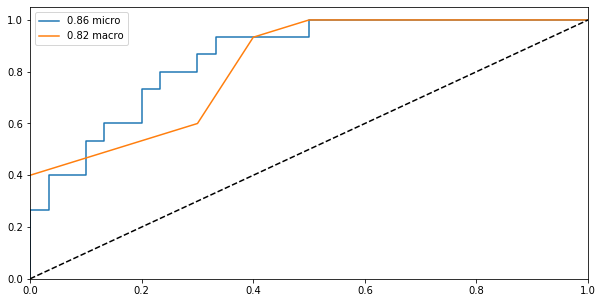

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(fpr['micro'], tpr['micro'], label=f'{roc_auc["micro"]:.2} micro')
ax.plot(fpr['macro'], tpr['macro'], label=f'{roc_auc["macro"]:.2} macro')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend()